In [25]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

import torch
import numpy as np
from sklearn.metrics import r2_score

from heteroscedastic import BetaGaussianMLP, BetaGaussianLM, _radius

In [2]:
df_train_all = pd.read_csv('../data/cars2010.csv')
df_test_all = pd.read_csv('../data/cars2011.csv')

In [3]:
df_train_all

,EngDispl,NumCyl,Transmission,FE,AirAspirationMethod,NumGears,TransLockup,TransCreeperGear,DriveDesc,IntakeValvePerCyl,ExhaustValvesPerCyl,CarlineClassDesc,VarValveTiming,VarValveLift
0,4.7,8,AM6,28.0198,NaturallyAspirated,6,1,0,TwoWheelDriveRear,2,2,2Seaters,1,0
1,4.7,8,M6,25.6094,NaturallyAspirated,6,1,0,TwoWheelDriveRear,2,2,2Seaters,1,0
2,4.2,8,M6,26.8000,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,2Seaters,1,0
3,4.2,8,AM6,25.0451,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,2Seaters,1,0
4,5.2,10,AM6,24.8000,NaturallyAspirated,6,0,0,AllWheelDrive,2,2,2Seaters,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,3.2,6,S6,30.4926,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,SpecialPurposeVehicleSUV4WD,1,0
1103,3.0,6,S6,29.7892,Turbocharged,6,1,0,AllWheelDrive,2,2,SpecialPurposeVehicleSUV4WD,1,0
1104,3.2,6,S6,30.4926,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,SpecialPurposeVehicleSUV4WD,1,0
1105,3.2,6,S6,29.7431,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,SpecialPurposeVehicleSUV4WD,1,0


In [6]:
df_train = df_train_all[['FE', 'EngDispl']].copy()
df_test = df_test_all[['FE', 'EngDispl']].copy()

In [11]:
df_train

,FE,EngDispl
0,28.0198,4.7
1,25.6094,4.7
2,26.8000,4.2
3,25.0451,4.2
4,24.8000,5.2
...,...,...
1102,30.4926,3.2
1103,29.7892,3.0
1104,30.4926,3.2
1105,29.7431,3.2


In [43]:
y, X = dmatrices('FE ~ EngDispl', data=df_train, return_type='dataframe')
y_test, X_test = dmatrices('FE ~ EngDispl', data=df_test, return_type='dataframe')

In [44]:
y

,FE
0,28.0198
1,25.6094
2,26.8000
3,25.0451
4,24.8000
...,...
1102,30.4926
1103,29.7892
1104,30.4926
1105,29.7431


In [45]:
X

,Intercept,EngDispl
0,1.0,4.7
1,1.0,4.7
2,1.0,4.2
3,1.0,4.2
4,1.0,5.2
...,...,...
1102,1.0,3.2
1103,1.0,3.0
1104,1.0,3.2
1105,1.0,3.2


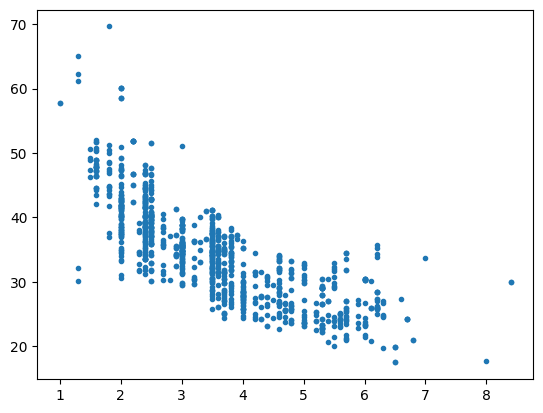

In [17]:
plt.scatter(X.EngDispl, y.FE, marker='.')

In [20]:
# Statistically confirm that the data is(/not) heteroscedastic

ols = sm.OLS(y, X)
ols_result = ols.fit()

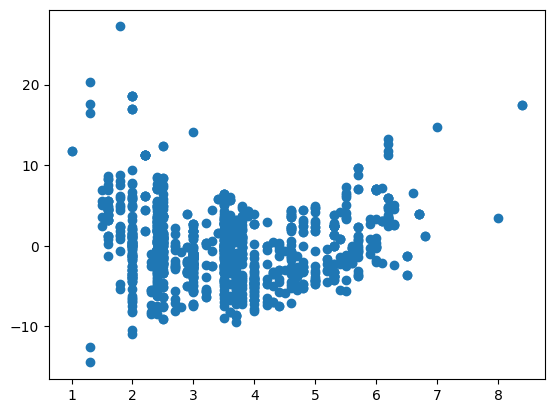

In [21]:
# residuals of a LM are dependent on X
plt.scatter(X.EngDispl, ols_result.resid)

In [22]:
# statistical tests confirm this:
het_white(ols_result.resid, X)

(117.7420093723202,
 2.707992895937063e-26,
 65.69933201376779,
 1.1000038748270134e-27)

In [23]:
het_breuschpagan(ols_result.resid, X, robust=False)

(18.460909072394315,
 1.7342523218751654e-05,
 7.9669749301300685,
 0.004849291991016873)

In [27]:
torch.set_default_dtype(torch.double)

In [47]:
X_train = torch.from_numpy(X.to_numpy())[:, 1].unsqueeze(-1)
y_train = torch.from_numpy(y.to_numpy()).squeeze()

X_test = torch.from_numpy(X_test.to_numpy())[:, 1].unsqueeze(-1)
y_test = torch.from_numpy(y_test.to_numpy()).squeeze()

In [29]:
X_torch

tensor([[4.7000],
        [4.7000],
        [4.2000],
        ...,
        [3.2000],
        [3.2000],
        [4.4000]])

In [30]:
# n_test = int(.1 * len(X_torch))
# X_test, X_train = X_torch[-n_test:], X_torch[:-n_test]
# y_test, y_train = y_torch[-n_test:], y_torch[:-n_test]

In [48]:
# normalize inputs
mu = X_train.mean(dim=0)
std = torch.norm(X_train - mu, dim=0)
# mu
# # std

In [49]:
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std
X_torch = (X_torch - mu) / std

In [50]:
def save_for_plot(model):
    alpha = model.alpha
    model.eval()
    
    t = torch.linspace(X_torch.min(), X_torch.max() + .1, 100).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred, sigma_sq = model(t)
        std_pred = sigma_sq.sqrt()
    
    t = t.squeeze().numpy()
    y_pred = y_pred.squeeze().numpy()
    std_pred = std_pred.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a = 2*std_pred
    else:
        # 100% confidence interval.
        R = _radius(1, alpha)
        tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
        a = np.sqrt(-2 * tau * std_pred**2)
        
    return t, y_pred, a
    

def plot_model(t, y_pred, a, ax, which="support", fill_color='C0'):
    ax.plot(t, y_pred, color='C0', label="predicted mean")

    ax.fill_between(t,
                    y_pred - a,
                    y_pred + a,
                    alpha=0.2, color=fill_color, label="predicted {}".format(which))
       
    # Plot the truth
    ax.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), marker='.', color='C1', label='train')
    ax.scatter(X_test.squeeze().numpy(), y_test.squeeze().numpy(), marker='x', color='C2', label='test')

    # ax.set_ylim(-10, 370)
    ax.set_xlim(None, t[-1])

In [51]:
# baseline

torch.manual_seed(42)
bl_model = BetaGaussianLM(input_size=1, uncertainty=False, heteroscedastic=False, alpha=None)
optimizer = torch.optim.LBFGS(bl_model.parameters(), lr=.01, max_iter=100)

n_epochs = 1000

for epoch in range(n_epochs):
    # Forward pass
    
    def closure():
        optimizer.zero_grad()
        bl_model.train()
        loss = bl_model.loss(X_train, y_train)
        loss.backward()
        return loss

    optimizer.step(closure)

# evaluate R^2
y_pred_train = bl_model.predict(X_train).detach().numpy()
y_pred_test = bl_model.predict(X_test).detach().numpy()
print("R2 train {:.3f} test {:.3f}".format(
    r2_score(y_pred_train, y_train.numpy()),
    r2_score(y_pred_test, y_test.numpy())))
    
print("w", bl_model.pred_y.weight.data, "b", bl_model.pred_y.bias.data)

R2 train 0.387 test 0.395
w tensor([[-196.3429]]) b tensor([34.7065])


In [72]:
# try lbfgs

old_loss = np.inf

n_epochs = 1000

results = []

for j, alpha in enumerate([1, 4/3, 1.5, 2]):
    torch.manual_seed(42)
    model = BetaGaussianLM(input_size=1, uncertainty=True, heteroscedastic=True, alpha=alpha)
    
    model.pred_y.weight.data[:] = bl_model.pred_y.weight
    model.pred_y.bias.data[:] = bl_model.pred_y.bias
    optimizer = torch.optim.LBFGS(model.parameters(), lr=.01, line_search_fn='strong_wolfe', max_iter=100)
    
    for epoch in range(n_epochs):
        
        def closure():
            optimizer.zero_grad()
            model.train()
            loss = model.loss(X_train, y_train)
            loss.backward()
            return loss
        
        optimizer.step(closure)
            
    # evaluate R^2
    model.eval()
    y_pred_train = model.predict(X_train).detach().numpy()
    y_pred_test = model.predict(X_test).detach().numpy()

    r2 = "R2 train {:.3f} test {:.3f}".format(
        r2_score(y_pred_train, y_train.numpy()),
        r2_score(y_pred_test, y_test.numpy()))
    
    results.append((alpha, save_for_plot(model), r2)) #save_for_plot(model),

In [69]:
results

[(1, 'R2 train 0.387 test 0.395'),
 (1.3333333333333333, 'R2 train 0.387 test 0.395'),
 (1.5, 'R2 train 0.387 test 0.395'),
 (2, 'R2 train 0.387 test 0.395')]

Text(0.5, 0, 'Standardized county population')

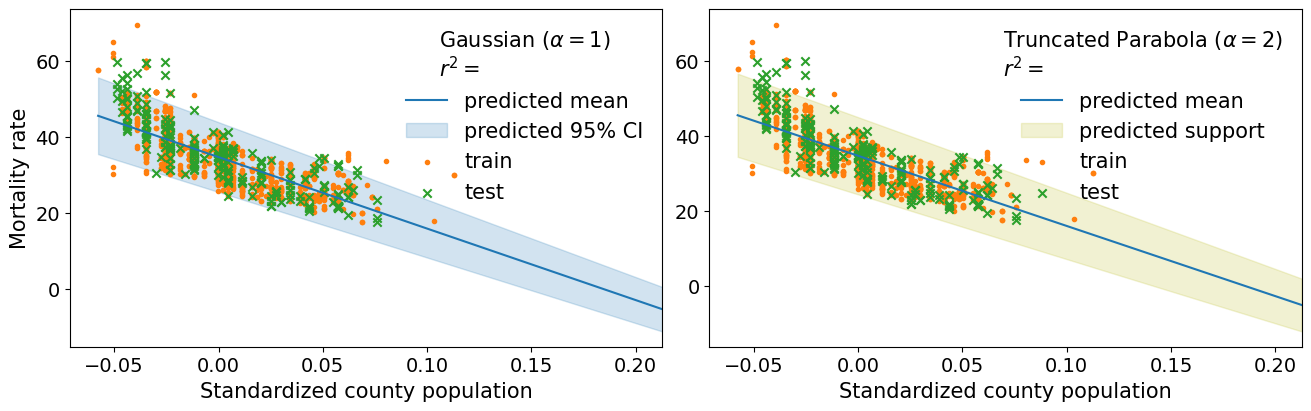

In [73]:
fig, (ax_gauss, ax_tp) = plt.subplots(1, 2, figsize=(13, 4), constrained_layout=True)

plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plot_model(*results[0][1], ax_gauss, "95% CI", fill_color='C0')
plot_model(*results[3][1], ax_tp, "support", fill_color='C8')
ax_gauss.legend(title="Gaussian ($\\alpha=1$)\n$r^2=$", fontsize=15)
ax_tp.legend(title="Truncated Parabola ($\\alpha=2$)\n$r^2=$", fontsize=15)
ax_gauss.set_ylabel("Mortality rate", fontsize=15)
ax_gauss.set_xlabel("Standardized county population", fontsize=15)
ax_tp.set_xlabel("Standardized county population", fontsize=15)
# plt.savefig("heteroscedastic.pdf")